<img src="https://www.dane.gov.co/files/images/logos/logo-dane.svg" alt="Universidade Federal do Ceará" style="width: 190px;" align="left" frameborder="300"/>

**DANE - Detección de anomalías** <br>
**Carlos Eduardo Gutiérrez Urueña**  <br><br>

# Tabla de contenido - Algoritmo Histogram-Based Outlier Score (HBOS)

- [Inicio](#Tabla-de-contenido)
- [Sección 1 - Anomalías EMICRON 2021](#Sección-1---Anomalías-EMICRON-2021)
- [Sección 2 - Anomalías EMICRON 2022](#Sección-2---Anomalías-EMICRON-2022)
- [Sección 3 - Anomalías EMICRON 2022](#Sección-3---Anomalías-EMICRON-2022)

In [1]:
import numpy as np
import pandas as pd
from pyod.utils.data import generate_data
from pyod.models.hbos import HBOS
import matplotlib.pyplot as plt
from pyod.models.combination import aom, moa, average, maximization # instalar la librería conda install combo
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS
from sklearn.model_selection import train_test_split

## Sección 1 - Anomalías EMICRON 2021

### Aplicación del algoritmo para todas las variables de la encuesta EMICRON 2021

In [2]:
# Importando los datos
emicron = pd.read_excel('emicron_21_final_ambulantes.xlsx')

In [7]:
#emicron['p3053'].head()
emicron.shape
#emicron['id'].head()
#len(emicron)

(2702, 157)

In [4]:
# Identificando las columnas que tienen 0 o nulos en todas sus filas
#emicron['p3092'].head().unique()
columnas_con_nan = emicron.columns[emicron.isna().sum() == len(emicron)]

In [5]:
# Identificando las filas con valores nulos
print(columnas_con_nan)

Index(['p3095', 'p3096', 'p3097', 'p3055', 'p3056_d', 'p3057_d', 'p3092',
       'p3093', 'p4017', 'p4018', 'p4031', 'p4032'],
      dtype='object')


In [6]:
# Se establece como índice del dataframe al identificador. Esto para identificar el código de los anómalos al final del proceso.
emicron.set_index('id', inplace = True)

In [9]:
# Eliminando las columnas que no se tienen en cuenta en el modelo (valores nulos e identificadores)
emicron.drop(['mes_ref', 'directorio', 'secuencia_p', 'secuencia_encuesta', 'p3095', 'p3096', 'p3055', 'p3097', 'p3056_d', 'p3057_d', 'p3092', 'p3093', 'p4017', 'p4018', 'p4031', 'p4032'], axis = 1, inplace = True)

In [10]:
emicron.dtypes

cod_depto                     int64
area                        float64
clase_te                      int64
p35                           int64
p241                          int64
                             ...   
ventas_mes_anterior           int64
ventas_mes_anio_anterior    float64
ventas_anio_anterior        float64
valor_agregado                int64
ingreso_mixto                 int64
Length: 141, dtype: object

In [16]:
# Borrando las posibles filas que tengan valores vacíos en toda las variables
emicron.dropna(how = 'all', axis = 0)

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4028,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto
id,,,,,,,,,,,,,,,,,,,,,
529996411,73,73.0,1,2,35,1,0.00000,0.000000,1.000000,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,180000,400000,1.369027e+06,8.000000e+05,116000,116000
530006311,63,63.0,1,1,61,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,300000,870000,8.700000e+05,7.830000e+06,300000,300000
530011312,76,76.0,1,2,49,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,700000,650000,8.000000e+05,6.000000e+06,300000,300000
530019511,50,50.0,1,2,38,1,0.00000,0.000000,2.000000,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,300000,700000,7.500000e+05,7.800000e+06,274000,274000
530044811,5,5.0,1,2,47,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,50000,700000,1.369027e+06,5.498833e+06,450000,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603359111,50,50.0,1,2,51,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,750000,1500000,1.369027e+06,1.526867e+07,750000,750000
603365811,50,50.0,1,1,25,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,500000,800000,1.369027e+06,1.526867e+07,490000,490000
603390811,50,50.0,1,2,48,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000e+00,0.000000,5.215741e+06,300000,700000,6.000000e+05,5.000000e+06,320000,320000


In [12]:
# Reemplazando los valores nan por el promedio
emicron = emicron.fillna(emicron.mean())

In [17]:
# Verificando que no existan valores nulos en el dataset
print(f"¿Existen valores nulos?: {emicron.isnull().values.any()}. ¿Cunántos valores nulos hay?: {emicron.isnull().sum().sum()}")

¿Existen valores nulos?: False. ¿Cunántos valores nulos hay?: 0


In [22]:
# Dividiendo el dataset en datos de entrenamiento y datos de validación

X_train, X_test = train_test_split(emicron, test_size = 0.3, random_state = 0)

In [23]:
#Observando algunos registros
X_train.head()

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4028,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto
id,,,,,,,,,,,,,,,,,,,,,
554192513,76,76.000000,1,2,66,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,100000,600000,0.0,3000000.0,140000,140000
557936913,47,36.133191,2,2,39,2,0.43254,0.279762,0.605159,2,...,59464.285714,558487.637363,9637.362637,5.215741e+06,900000,2700000,2500000.0,18500000.0,900000,900000
536955111,52,52.000000,1,1,33,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,500000,600000,400000.0,5000000.0,400000,400000
552299513,66,66.000000,1,2,55,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,600000,1600000,1600000.0,8300000.0,630000,630000
555056711,63,63.000000,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,0.000000,0.000000,5.215741e+06,900000,5200000,5000000.0,45000000.0,960000,960000


In [24]:
# Obteniendo la cantidad de datos que fueron divididos en entrenamiento y validación
print(f"El tamaño de los datos de entrenamiento es: {X_train.shape} y de validación: {X_test.shape}")

El tamaño de los datos de entrenamiento es: (1891, 141) y de validación: (811, 141)


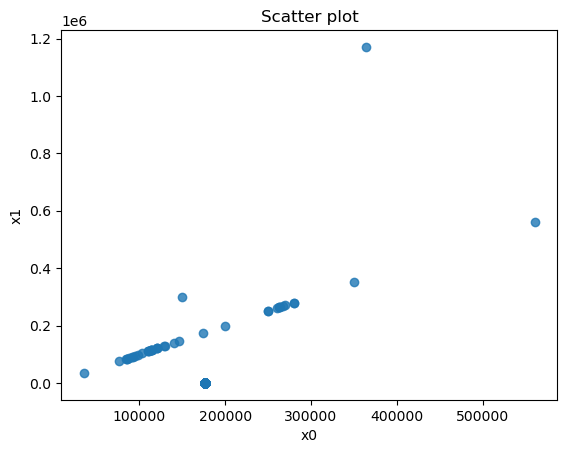

In [25]:
# Graficando las variables 0 y 1 en un scatter plot e identificando atípicos. Amarillo atípicos, morados, datos normales
plt.scatter(X_train['p3089'], X_train['prestaciones'], alpha = 0.8) # c es la lista de colores de acuerdo con los valores únicos de esta variable, la cual en la líne anterior es 1,0
plt.title("Scatter plot")
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [26]:
# Obteniendo un número arbitrario de bins o barras del histograma
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [28]:
#Obteniendo el Umbral
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  107.53627478551165


In [29]:
# Creando las puntuaciones para los datos de entrenamiento y prediciendo cuando una instancia es atípica o no
# la función predict compara la puntuación de los datos atípicoscon el umbral. Si la puntuación de un atípico es mayor al umbral, la función asigna 1, o en caso contrario , 0
# Datos de entrenamiento

Y_train_scores = hbos.decision_function(X_train)
Y_train_pred = hbos.predict(X_train)

# Datos de testeo o validación
Y_test_scores = hbos.decision_function(X_test)
Y_test_pred = hbos.predict(X_test)

In [30]:
Y_train_pred
#contanto el número de valores predichos
def count_stat(vector):
    unique, counts = np.unique(vector,
                               return_counts = True)
    return dict(zip(unique, counts))

print("Los datos de entrenamiento: ", count_stat(Y_train_pred))
print("Los datos de validación o test: ", count_stat(Y_test_pred))

Los datos de entrenamiento:  {0: 1796, 1: 95}
Los datos de validación o test:  {0: 774, 1: 37}


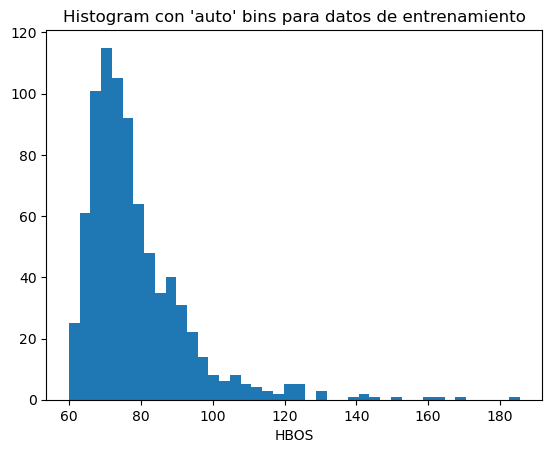

In [31]:
plt.hist(Y_test_scores, bins = 'auto')
plt.title("Histogram con 'auto' bins para datos de entrenamiento")
plt.xlabel('HBOS')
plt.show()

In [32]:
threshold = hbos.threshold_

In [33]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [34]:
# Obteniendo la tabla resumen de outliers en la data de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score
0,Normal,1796,94.976203,36.39,35.63,1.03,1.50,47.51,1.82,0.42,...,631815.69,11933.96,5218308.07,537967.35,1799270.59,1325875.58,14764984.89,598887.56,562882.81,76.77
1,Outlier,95,5.023797,41.99,40.99,1.04,1.44,48.64,1.53,0.68,...,511299.54,12884.67,5192417.15,801625.33,4596112.19,3429936.95,39449147.58,1253838.49,940702.75,123.75


In [35]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
554192513,76,76.000000,1,2,66,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,100000,600000,0.000000e+00,3.000000e+06,140000,140000,63.167654,Normal
557936913,47,36.133191,2,2,39,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,900000,2700000,2.500000e+06,1.850000e+07,900000,900000,72.124016,Normal
536955111,52,52.000000,1,1,33,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,500000,600000,4.000000e+05,5.000000e+06,400000,400000,77.053967,Normal
552299513,66,66.000000,1,2,55,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,600000,1600000,1.600000e+06,8.300000e+06,630000,630000,72.228609,Normal
555056711,63,63.000000,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,900000,5200000,5.000000e+06,4.500000e+07,960000,960000,94.199018,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551148611,54,54.000000,1,2,32,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,190000,700000,0.000000e+00,0.000000e+00,170000,170000,65.801212,Normal
540582913,23,23.000000,1,2,36,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,40000,120000,1.369027e+06,1.526867e+07,40000,40000,63.363330,Normal
541534412,20,36.133191,1,1,47,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,400000,1200000,1.369027e+06,1.526867e+07,400000,400000,71.764596,Normal


In [36]:
# Obteniendo la tabla resumen de outliers en la data de validación
descriptive_stat_threshold(X_test, Y_test_scores, threshold)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score
0,Normal,774,95.437731,37.28,36.42,1.02,1.52,47.28,1.84,0.40,...,410723.95,4196.11,5212646.19,531106.32,1611417.34,1182703.93,12862720.91,601720.50,584360.10,76.27
1,Outlier,37,4.562269,43.81,42.09,1.00,1.38,44.84,1.43,0.89,...,211319.65,3646.57,5215740.74,935947.46,3403951.11,2069798.31,27962433.04,1556246.68,974480.46,126.98


In [37]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_test, Y_test_scores, threshold, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
531334611,54,54.0,1,1,67,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,300000,600000,1.369027e+06,3.000000e+06,270000,270000,82.414586,Normal
555511311,18,18.0,1,1,76,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,350000,400000,5.000000e+05,6.000000e+06,255000,255000,103.585011,Normal
542214811,73,73.0,1,2,60,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,250000,600000,0.000000e+00,4.000000e+06,552500,552500,97.068251,Normal
551061212,19,19.0,1,1,61,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,389412,870000,8.166660e+05,4.225000e+06,389412,389412,72.459569,Normal
546571811,8,8.0,1,2,39,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,600000,2160000,1.369027e+06,1.526867e+07,681000,681000,64.394101,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553237511,8,8.0,1,1,59,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,400000,550000,3.000000e+05,4.650000e+06,406000,406000,71.877671,Normal
554000712,23,23.0,1,1,59,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,100000,200000,3.000000e+05,2.500000e+06,100000,100000,85.313294,Normal
601662015,76,76.0,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,80000,1600000,9.600000e+05,2.000000e+06,1015000,1015000,119.235518,Outlier


In [39]:
# Corroborando este dato outlier, con id = 601662015, en la base original:
emicron.loc[601662015,:]

cod_depto                        76.0
area                             76.0
clase_te                          1.0
p35                               2.0
p241                             58.0
                              ...    
ventas_mes_anterior         1600000.0
ventas_mes_anio_anterior     960000.0
ventas_anio_anterior        2000000.0
valor_agregado              1015000.0
ingreso_mixto               1015000.0
Name: 601662015, Length: 141, dtype: float64

In [40]:
# Estandarizando los datos

X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Generando diez modelos HBOS por rangos de 5, 10, 15, 20, 25, 30, 50, 60, 70 y 100 bins
# testando el rango de agrupaciones (binning)
k_list = [5,10,15,20,25,30,50,60,75,100]
n_clf = len(k_list)
# Se crea un dataframe vacío para los datos de entrenamiento y de test para almacenar las predicciones. Habrá diez modelos por lo que el data frame tendrá 10 columnas
#Almacenar los resultados
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modelando

for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins = n_bins)
    hbos.fit(X_train_norm)
    # Almacenando los resultados en cada columna
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)

# Normzalizando los puntajes de decision después de combinarlos
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)
    


In [41]:
train_scores_norm

array([[-0.79275645, -0.79275645, -0.79275645, ..., -0.79275645,
        -0.79275645, -0.79275645],
       [-0.5556407 , -0.5556407 , -0.5556407 , ..., -0.5556407 ,
        -0.5556407 , -0.5556407 ],
       [-0.16165336, -0.16165336, -0.16165336, ..., -0.16165336,
        -0.16165336, -0.16165336],
       ...,
       [-0.98177141, -0.98177141, -0.98177141, ..., -0.98177141,
        -0.98177141, -0.98177141],
       [ 0.63083245,  0.63083245,  0.63083245, ...,  0.63083245,
         0.63083245,  0.63083245],
       [ 0.56717608,  0.56717608,  0.56717608, ...,  0.56717608,
         0.56717608,  0.56717608]])

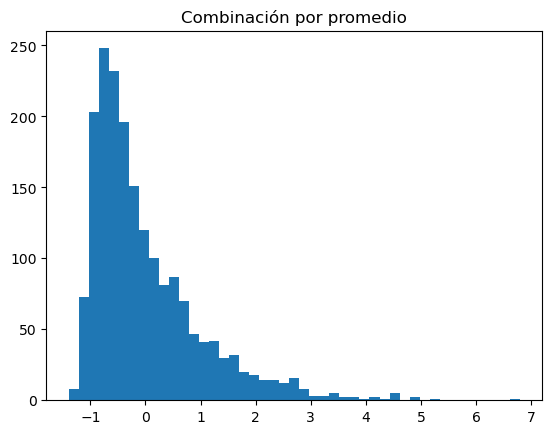

In [42]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_train_by_average = average(train_scores_norm)
Y_test_by_average = average(test_scores_norm)
plt.hist(Y_train_by_average, bins = 'auto')
plt.title("Combinación por promedio")
plt.show()

In [43]:
descriptive_stat_threshold(X_train, Y_train_by_average, 4)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score
0,Normal,1878,99.312533,36.68,35.92,1.03,1.50,47.56,1.81,0.43,...,587239.10,12028.74,5218195.97,543846.52,1849909.82,1343219.67,1.502805e+07,613617.52,572768.91,-0.03
1,Outlier,13,0.687467,35.46,32.02,1.08,1.23,48.38,1.08,1.80,...,6190724.11,5189.35,5045299.15,1615384.62,14922307.69,14196153.85,1.571467e+08,3257154.77,1895713.54,4.69


In [44]:
descriptive_stat_threshold(X_train, Y_train_by_average, 4, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
554192513,76,76.000000,1,2,66,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,100000,600000,0.000000e+00,3.000000e+06,140000,140000,-0.792756,Normal
557936913,47,36.133191,2,2,39,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,900000,2700000,2.500000e+06,1.850000e+07,900000,900000,-0.555641,Normal
536955111,52,52.000000,1,1,33,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,500000,600000,4.000000e+05,5.000000e+06,400000,400000,-0.161653,Normal
552299513,66,66.000000,1,2,55,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,600000,1600000,1.600000e+06,8.300000e+06,630000,630000,-0.421105,Normal
555056711,63,63.000000,1,2,58,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,900000,5200000,5.000000e+06,4.500000e+07,960000,960000,2.065064,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551148611,54,54.000000,1,2,32,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,190000,700000,0.000000e+00,0.000000e+00,170000,170000,-0.973554,Normal
540582913,23,23.000000,1,2,36,2,0.43254,0.279762,0.605159,2,...,0.000000,5.215741e+06,40000,120000,1.369027e+06,1.526867e+07,40000,40000,-1.131752,Normal
541534412,20,36.133191,1,1,47,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,400000,1200000,1.369027e+06,1.526867e+07,400000,400000,-0.981771,Normal


In [45]:
tabla_anomalos_emicron = descriptive_stat_threshold(X_train, Y_train_by_average, 4, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24764\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


In [52]:
atipicos = tabla_anomalos_emicron[tabla_anomalos_emicron['Group'] == 'Outlier']
atipicos.head()

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto,Anomaly_Score,Group
id,,,,,,,,,,,,,,,,,,,,,
538096711,54,54.000000,1,1,36,1,1.00000,0.000000,1.000000,1,...,9637.362637,3.000000e+06,1100000,2700000,1000000.0,3000000.0,1552000,1152000,4.084699,Outlier
553311411,18,18.000000,1,2,40,1,3.00000,1.000000,1.000000,1,...,0.000000,5.215741e+06,1350000,10800000,4680000.0,51860000.0,3904211,859271,5.164064,Outlier
536426411,76,36.133191,1,1,35,1,1.00000,1.000000,0.000000,1,...,0.000000,5.215741e+06,1500000,3600000,3000000.0,33000000.0,2187917,1687917,4.307603,Outlier
552741011,47,47.000000,1,1,43,1,2.00000,0.000000,1.000000,1,...,0.000000,5.215741e+06,2250000,7280000,5850000.0,76570000.0,3426000,2516000,4.053300,Outlier
535771211,8,8.000000,1,1,38,2,0.43254,0.279762,0.605159,2,...,9637.362637,5.215741e+06,2300000,26800000,44000000.0,367500000.0,2360000,2220000,4.437755,Outlier


In [53]:
#atipicos.to_excel('HBOS_tabla_anomalos_emicron21.xlsx', index = True)

## Sección 2 - Anomalías EMICRON 2022
Todas las variables EMICRON
### [Ir al inicio](#Tabla-de-contenido)


### Aplicación del algoritmo HBOS para toda las variables de la encuesta EMICRON

In [40]:
# Importando los datos
emicron = pd.read_excel('datos/emicron22_ambulantes.xlsx')

In [41]:
#emicron['p3053'].head()
emicron.shape
#emicron['id'].head()
#len(emicron)

(9510, 194)

In [42]:
emicron.head()

,directorio,secuencia_p,secuencia_encuesta,cod_depto,area,clase_te,p35,p241,mes_ref,p3031,...,p3014,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,ola
0,2120026,1,2,8,NaN,1,1,22,ENERO,2,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2022
1,2120053,1,2,8,NaN,1,1,61,ENERO,2,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2022
2,2120177,1,1,8,NaN,2,1,51,ENERO,1,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2022
3,2120201,1,2,8,NaN,2,2,21,ENERO,2,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2022
4,2120206,1,2,8,NaN,2,2,66,ENERO,2,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2022


In [43]:
# Identificando las columnas que tienen 0 o nulos en todas sus filas
#emicron['p3092'].head().unique()
columnas_con_nan = list(emicron.columns[emicron.isna().sum() == len(emicron)])

In [44]:
# Identificando las filas con valores nulos
print(columnas_con_nan)

['p3095', 'p3096', 'p3097', 'p3055', 'p3056_e', 'p3057_e', 'p3018_1', 'p3018_2', 'p3018_3', 'p3018_4', 'p3018_5', 'p3018_6', 'p3018_7', 'p3018_a', 'p3018_b', 'p3018_c', 'p3018_d', 'p3018_e', 'p3018_f', 'p3019', 'p3068_ene', 'p3068_feb', 'p3068_mar', 'p3068_abr', 'p3068_may', 'p3068_jun', 'p3068_jul', 'p3068_ago', 'p3068_sep', 'p3068_oct', 'p3068_nov', 'p3068_dic', 'p3068_tod', 'p3068_nin', 'p1764_6', 'p1764_7']


In [45]:
emicron.drop(columnas_con_nan, axis = 1, inplace = True)

In [46]:
emicron['id']

0       212002612
1       212005312
2       212017711
3       212020112
4       212020612
          ...    
9505    727685113
9506    727689011
9507    727690611
9508    727696412
9509    727696611
Name: id, Length: 9510, dtype: int64

In [47]:
# Se establece como índice del dataframe al identificador. Esto para identificar el código de los anómalos al final del proceso.
emicron.set_index('directorio', inplace = True)

In [48]:
# Eliminando las columnas que no se tienen en cuenta en el modelo (valores nulos e identificadores)
emicron.drop(['mes_ref', 'id', 'secuencia_p', 'secuencia_encuesta', 'ola'], axis = 1, inplace = True)

In [51]:
emicron.shape

(9510, 152)

In [50]:
# Borrando las posibles filas que tengan valores vacíos en toda las variables
emicron.dropna(how = 'all', axis = 0)

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p1572_6,p3014,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771
directorio,,,,,,,,,,,,,,,,,,,,,
2120026,8,NaN,1,1,22,2,NaN,NaN,NaN,2,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2120053,8,NaN,1,1,61,2,NaN,NaN,NaN,2,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2120177,8,NaN,2,1,51,1,1.0,0.0,0.0,1,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2120201,8,NaN,2,2,21,2,NaN,NaN,NaN,2,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2120206,8,NaN,2,2,66,2,NaN,NaN,NaN,2,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7276851,88,88.0,1,2,32,1,2.0,0.0,0.0,1,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0
7276890,20,NaN,1,1,63,2,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276906,54,54.0,1,2,42,2,NaN,NaN,NaN,2,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [52]:
# Reemplazando los valores nan por el promedio
emicron = emicron.fillna(emicron.mean())

In [53]:
# Verificando que no existan valores nulos en el dataset
print(f"¿Existen valores nulos?: {emicron.isnull().values.any()}. ¿Cunántos valores nulos hay?: {emicron.isnull().sum().sum()}")

¿Existen valores nulos?: False. ¿Cunántos valores nulos hay?: 0


In [54]:
# Dividiendo el dataset en datos de entrenamiento y datos de validación

X_train, X_test = train_test_split(emicron, test_size = 0.3, random_state = 0)

In [55]:
X_train.head()

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p1572_6,p3014,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771
directorio,,,,,,,,,,,,,,,,,,,,,
7167833,73,73.0,1,2,58,2,0.322425,0.348412,0.526468,2,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222
7238788,5,5.0,1,1,63,2,0.322425,0.348412,0.526468,2,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222
7167485,68,68.0,1,2,28,2,0.322425,0.348412,0.526468,2,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222
7244532,66,66.0,1,1,62,2,0.322425,0.348412,0.526468,2,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222
7062723,13,13.0,1,1,62,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.037575,6.000000


In [56]:
print(f"El tamaño de los datos de entrenamiento es: {X_train.shape} y de validación: {X_test.shape}")

El tamaño de los datos de entrenamiento es: (6657, 152) y de validación: (2853, 152)


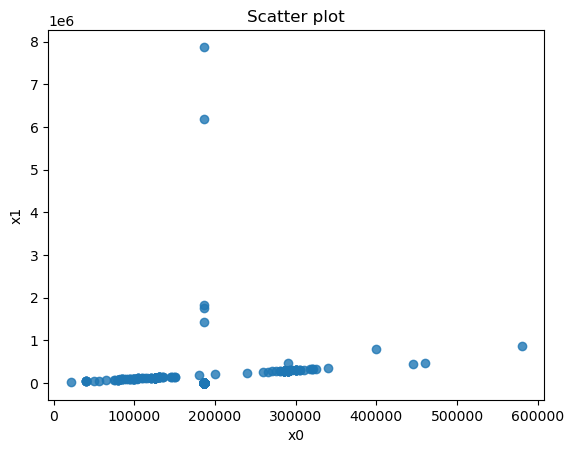

In [57]:
# Graficando las variables 0 y 1 en un scatter plot e identificando atípicos. Amarillo atípicos, morados, datos normales
plt.scatter(X_train['p3089'], X_train['prestaciones'], alpha = 0.8) # c es la lista de colores de acuerdo con los valores únicos de esta variable, la cual en la líne anterior es 1,0
plt.title("Scatter plot")
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [58]:
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [59]:
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  234.63544164251556


In [60]:
# Creando las puntuaciones para los datos de entrenamiento y prediciendo cuando una instancia es atípica o no
# la función predict compara la puntuación de los datos atípicoscon el umbral. Si la puntuación de un atípico es mayor al umbral, la función asigna 1, o en caso contrario , 0
# Datos de entrenamiento

Y_train_scores = hbos.decision_function(X_train)
Y_train_pred = hbos.predict(X_train)

# Datos de testeo o validación
Y_test_scores = hbos.decision_function(X_test)
Y_test_pred = hbos.predict(X_test)

In [61]:
Y_train_pred
#contanto el número de valores predichos
def count_stat(vector):
    unique, counts = np.unique(vector,
                               return_counts = True)
    return dict(zip(unique, counts))

print("Los datos de entrenamiento: ", count_stat(Y_train_pred))
print("Los datos de validación o test: ", count_stat(Y_test_pred))

Los datos de entrenamiento:  {0: 6324, 1: 333}
Los datos de validación o test:  {0: 2693, 1: 160}


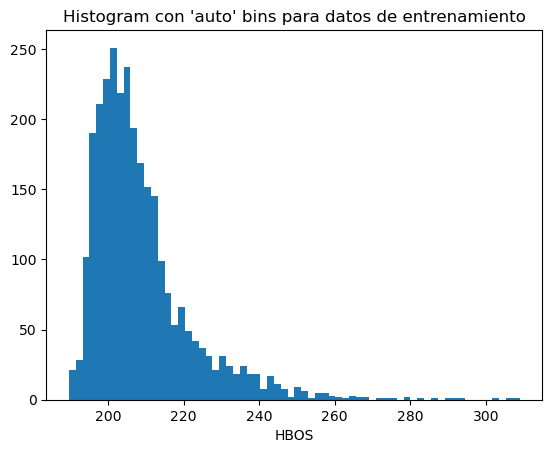

In [62]:
plt.hist(Y_test_scores, bins = 'auto')
plt.title("Histogram con 'auto' bins para datos de entrenamiento")
plt.xlabel('HBOS')
plt.show()

In [63]:
threshold = hbos.threshold_

In [64]:
threshold

234.63544164251556

In [65]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [66]:
# Obteniendo la tabla resumen de outliers en la data de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p3014,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score
0,Normal,6324,94.997747,37.85,37.94,1.07,1.37,46.25,1.93,0.31,...,1.91,1.0,1.0,1.0,1.0,1.0,1.0,1.04,5.65,206.86
1,Outlier,333,5.002253,38.55,38.84,1.07,1.45,45.18,1.20,0.52,...,1.68,1.0,1.0,1.0,1.0,1.0,1.0,1.05,5.52,248.12


In [67]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7167833,73,73.000000,1,2,58,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,220.124121,Normal
7238788,5,5.000000,1,1,63,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,205.314755,Normal
7167485,68,68.000000,1,2,28,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,211.935647,Normal
7244532,66,66.000000,1,1,62,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,192.709596,Normal
7062723,13,13.000000,1,1,62,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.037575,6.000000,198.315247,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211638,68,68.000000,1,1,41,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,207.912308,Normal
7263298,52,52.000000,1,1,40,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,201.232305,Normal
7095502,23,23.000000,1,1,32,1,1.000000,0.000000,0.000000,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,231.776260,Normal


In [68]:
# Obteniendo la tabla resumen de outliers en la data de validación
descriptive_stat_threshold(X_test, Y_test_scores, threshold)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p3014,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score
0,Normal,2693,94.391868,37.69,37.36,1.06,1.37,46.51,1.94,0.32,...,1.91,1.0,1.0,1.0,1.0,1.0,1.0,1.03,5.64,206.41
1,Outlier,160,5.608132,43.13,41.05,1.11,1.43,43.76,1.19,0.46,...,1.66,1.0,1.0,1.0,1.0,1.0,1.0,1.05,5.46,248.01


In [69]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_test, Y_test_scores, threshold, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7187679,8,8.000000,1,1,35,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,208.757177,Normal
2127243,8,8.000000,1,1,22,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.037575,6.000000,203.189771,Normal
7255580,50,50.000000,1,1,45,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,204.387544,Normal
7191078,54,54.000000,1,2,71,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,218.657184,Normal
7240626,44,37.861222,2,1,37,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,201.351567,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108211,23,37.861222,1,2,66,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,207.995705,Normal
7074974,17,17.000000,1,2,21,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,195.668183,Normal
7002123,47,47.000000,1,1,28,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,200.771113,Normal


In [39]:
# Corroborando este dato outlier, con id = 601662015, en la base original:
emicron.loc[601662015,:]

cod_depto                        76.0
area                             76.0
clase_te                          1.0
p35                               2.0
p241                             58.0
                              ...    
ventas_mes_anterior         1600000.0
ventas_mes_anio_anterior     960000.0
ventas_anio_anterior        2000000.0
valor_agregado              1015000.0
ingreso_mixto               1015000.0
Name: 601662015, Length: 141, dtype: float64

In [70]:
# Estandarizando los datos

X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Generando diez modelos HBOS por rangos de 5, 10, 15, 20, 25, 30, 50, 60, 70 y 100 bins
# testando el rango de agrupaciones (binning)
k_list = [5,10,15,20,25,30,50,60,75,100]
n_clf = len(k_list)
# Se crea un dataframe vacío para los datos de entrenamiento y de test para almacenar las predicciones. Habrá diez modelos por lo que el data frame tendrá 10 columnas
#Almacenar los resultados
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modelando

for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins = n_bins)
    hbos.fit(X_train_norm)
    # Almacenando los resultados en cada columna
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)

# Normzalizando los puntajes de decision después de combinarlos
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

In [91]:
train_scores_norm

array([[ 0.370342  ,  0.370342  ,  0.370342  , ...,  0.370342  ,
         0.370342  ,  0.370342  ],
       [ 0.4636029 ,  0.4636029 ,  0.4636029 , ...,  0.4636029 ,
         0.4636029 ,  0.4636029 ],
       [ 0.10564853,  0.10564853,  0.10564853, ...,  0.10564853,
         0.10564853,  0.10564853],
       ...,
       [ 2.85661692,  2.85661692,  2.85661692, ...,  2.85661692,
         2.85661692,  2.85661692],
       [-0.62814014, -0.62814014, -0.62814014, ..., -0.62814014,
        -0.62814014, -0.62814014],
       [ 0.66345622,  0.66345622,  0.66345622, ...,  0.66345622,
         0.66345622,  0.66345622]])

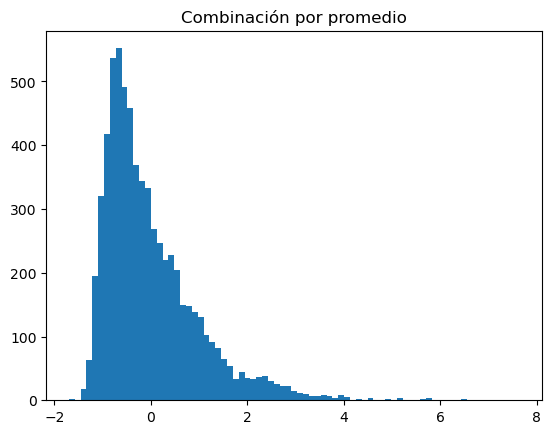

In [97]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_train_by_average = average(train_scores_norm)
Y_test_by_average = average(test_scores_norm)
plt.hist(Y_train_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [81]:
# Dado que el histograma anterior sugiere que el umbral esté por encima de 4.2, este será el umbral para categorizar lo valores anómalos
descriptive_stat_threshold(X_train, Y_train_by_average, 4.2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,Group,Count,Count %,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,...,p3014,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score
0,Normal,6630,99.594412,37.87,37.98,1.07,1.37,46.20,1.89,0.32,...,1.90,1.0,1.0,1.0,1.0,1.0,1.0,1.04,5.65,-0.02
1,Outlier,27,0.405588,40.63,39.37,1.07,1.19,45.74,1.04,1.57,...,1.67,1.0,1.0,1.0,1.0,1.0,1.0,1.05,5.58,5.43


In [82]:
descriptive_stat_threshold(X_train, Y_train_by_average, 4.2, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7167833,73,73.000000,1,2,58,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,0.370342,Normal
7238788,5,5.000000,1,1,63,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,0.463603,Normal
7167485,68,68.000000,1,2,28,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,0.105649,Normal
7244532,66,66.000000,1,1,62,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,-0.904321,Normal
7062723,13,13.000000,1,1,62,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.037575,6.000000,0.825832,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211638,68,68.000000,1,1,41,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,-0.525848,Normal
7263298,52,52.000000,1,1,40,2,0.322425,0.348412,0.526468,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,-0.807515,Normal
7095502,23,23.000000,1,1,32,1,1.000000,0.000000,0.000000,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,2.856617,Normal


In [85]:
tabla_anomalos_emicron = descriptive_stat_threshold(X_train, Y_train_by_average, 4.2, 2)

C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Anomaly_Score'] = pred_score
C:\Users\cegut\AppData\Local\Temp\ipykernel_24812\4151893686.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')


In [86]:
atipicos = tabla_anomalos_emicron[tabla_anomalos_emicron['Group'] == 'Outlier']
atipicos.head()

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p1573_1,p1573_2,p1573_3,p1573_4,p1573_5,p1573_6,p1574,p1771,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7008785,50,50.000000,1,2,46,1,1.0,0.0,0.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,4.937269,Outlier
7032920,18,18.000000,1,1,21,1,0.0,1.0,0.0,2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,5.188957,Outlier
2124194,17,37.861222,2,1,27,1,2.0,0.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.037575,6.000000,6.180000,Outlier
2146259,88,88.000000,1,1,69,1,1.0,0.0,0.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,5.886458,Outlier
7253009,8,8.000000,1,1,71,1,2.0,0.0,0.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,5.642222,5.044177,Outlier


In [89]:
atipicos['Anomaly_Score'].mean()

5.434964890664475

In [87]:
atipicos.to_excel('datos/HBOS_tabla_anomalos_emicron22.xlsx', index = True)

## Sección 3 - Anomalías EMICRON 2022
Variables homologadas EMICRON -CENU
### [Ir al inicio](#Tabla-de-contenido)

### Aplicación del algoritmo para las variables homologadas entre la encuesta EMICRON y CENU

In [33]:
# Importando los datos
emicron = pd.read_excel('datos/emicron22_ambulantes.xlsx')
variables = pd.read_csv('datos/variables_emicron_cenu.csv')

In [34]:
#emicron['p3053'].head()
#emicron.shape
#emicron['id'].head()
#len(emicron)
variables = variables['variables'].str.lower()
variables.head()

0    cod_depto
1         area
2      p3032_1
3      p3032_2
4      p3032_3
Name: variables, dtype: object

In [35]:
emicron.set_index('directorio', inplace = True)

In [38]:
emicron = emicron[variables]
# variables_e = pd.DataFrame(emicron.columns)
# variables_e.to_excel('variables_e.xlsx', index = False)

In [47]:
#emicron.shape
emicron.head()

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p3017_h,p3017_k,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765
directorio,,,,,,,,,,,,,,,,,,,,,
2120026,8,NaN,NaN,NaN,NaN,3,5,1,4,NaN,...,0,0,NaN,NaN,NaN,NaN,3600000.0,NaN,1.0,2.0
2120053,8,NaN,NaN,NaN,NaN,3,5,5,4,1.0,...,0,60000,NaN,NaN,NaN,NaN,43000000.0,NaN,1.0,2.0
2120177,8,NaN,1.0,0.0,0.0,2,3,5,4,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,85000000.0,1.0,2.0
2120201,8,NaN,NaN,NaN,NaN,3,5,2,4,1.0,...,0,0,NaN,NaN,NaN,NaN,50600000.0,NaN,1.0,1.0
2120206,8,NaN,NaN,NaN,NaN,3,5,5,4,NaN,...,0,0,NaN,NaN,NaN,NaN,100000000.0,NaN,1.0,1.0


In [41]:
# Identificando las columnas que tienen 0 o nulos en todas sus filas
#emicron['p3092'].head().unique()
columnas_con_nan = list(emicron.columns[emicron.isna().sum() == len(emicron)])

In [42]:
# Identificando las filas con valores nulos
print(columnas_con_nan)

['p3018_7', 'p3018_a', 'p3018_b', 'p3018_c', 'p3018_d', 'p3018_e', 'p3018_f', 'p3019', 'p3068_ene', 'p3068_feb', 'p3068_mar', 'p3068_abr', 'p3068_may', 'p3068_jun', 'p3068_jul', 'p3068_ago', 'p3068_sep', 'p3068_oct', 'p3068_nov', 'p3068_dic', 'p3068_tod', 'p3068_nin']


In [43]:
emicron.drop(columnas_con_nan, axis = 1, inplace = True)

C:\Users\cegut\AppData\Local\Temp\ipykernel_28576\3082764500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emicron.drop(columnas_con_nan, axis = 1, inplace = True)


In [51]:
emicron['area']

directorio
2120026     NaN
2120053     NaN
2120177     NaN
2120201     NaN
2120206     NaN
           ... 
7276851    88.0
7276890     NaN
7276906    54.0
7276964    20.0
7276966    23.0
Name: area, Length: 9510, dtype: float64

In [47]:
# Se establece como índice del dataframe al identificador. Esto para identificar el código de los anómalos al final del proceso.
emicron.set_index('directorio', inplace = True)

In [54]:
emicron.shape

(9510, 42)

In [53]:
# Borrando las posibles filas que tengan valores vacíos en toda las variables
emicron.dropna(how = 'all', axis = 0)

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p3017_h,p3017_k,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765
directorio,,,,,,,,,,,,,,,,,,,,,
2120026,8,NaN,NaN,NaN,NaN,3,5,1,4,NaN,...,0,0,NaN,NaN,NaN,NaN,3600000.0,NaN,1.0,2.0
2120053,8,NaN,NaN,NaN,NaN,3,5,5,4,1.0,...,0,60000,NaN,NaN,NaN,NaN,43000000.0,NaN,1.0,2.0
2120177,8,NaN,1.0,0.0,0.0,2,3,5,4,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,85000000.0,1.0,2.0
2120201,8,NaN,NaN,NaN,NaN,3,5,2,4,1.0,...,0,0,NaN,NaN,NaN,NaN,50600000.0,NaN,1.0,1.0
2120206,8,NaN,NaN,NaN,NaN,3,5,5,4,NaN,...,0,0,NaN,NaN,NaN,NaN,100000000.0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7276851,88,88.0,2.0,0.0,0.0,4,12,2,4,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,33000000.0,1.0,2.0
7276890,20,NaN,NaN,NaN,NaN,2,3,2,4,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
7276906,54,54.0,NaN,NaN,NaN,4,7,4,4,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,9500000.0,1.0,1.0


In [55]:
# Reemplazando los valores nan por el promedio
emicron = emicron.fillna(emicron.mean())

In [56]:
# Verificando que no existan valores nulos en el dataset
print(f"¿Existen valores nulos?: {emicron.isnull().values.any()}. ¿Cunántos valores nulos hay?: {emicron.isnull().sum().sum()}")

¿Existen valores nulos?: False. ¿Cunántos valores nulos hay?: 0


In [57]:
# Dividiendo el dataset en datos de entrenamiento y datos de validación

X_train, X_test = train_test_split(emicron, test_size = 0.3, random_state = 0)

In [59]:
X_train.head()

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p3017_h,p3017_k,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765
directorio,,,,,,,,,,,,,,,,,,,,,
7167833,73,73.0,0.322425,0.348412,0.526468,4,9,5,4,1.063586,...,0,0,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,1.600000e+07,1.0,2.0
7238788,5,5.0,0.322425,0.348412,0.526468,3,5,4,4,1.063586,...,0,0,1.590969e+07,0.0,348275.862069,17854.40613,3.996947e+07,1.459818e+07,1.0,2.0
7167485,68,68.0,0.322425,0.348412,0.526468,4,7,2,4,1.063586,...,0,0,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,7.200000e+06,1.0,1.0
7244532,66,66.0,0.322425,0.348412,0.526468,3,5,5,4,1.063586,...,0,0,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,6.000000e+06,1.0,2.0
7062723,13,13.0,0.322425,0.348412,0.526468,3,5,5,4,1.000000,...,0,0,1.590969e+07,0.0,348275.862069,17854.40613,7.920000e+07,1.459818e+07,1.0,2.0


In [60]:
print(f"El tamaño de los datos de entrenamiento es: {X_train.shape} y de validación: {X_test.shape}")

El tamaño de los datos de entrenamiento es: (6657, 42) y de validación: (2853, 42)


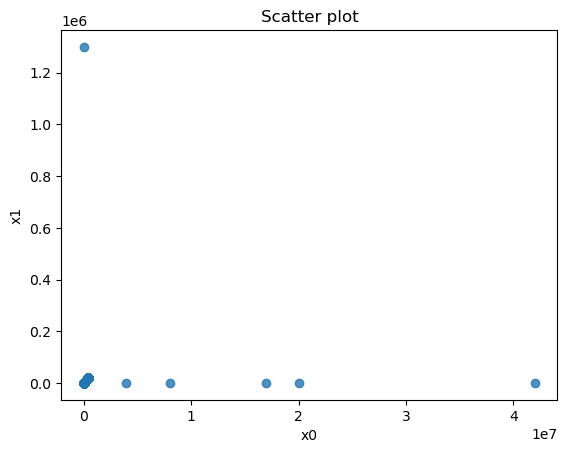

In [63]:
# Graficando las variables 0 y 1 en un scatter plot e identificando atípicos. Amarillo atípicos, morados, datos normales
plt.scatter(X_train['p4021'], X_train['p4022'], alpha = 0.8) # c es la lista de colores de acuerdo con los valores únicos de esta variable, la cual en la líne anterior es 1,0
plt.title("Scatter plot")
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [64]:
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [65]:
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  32.29287805264419


In [66]:
# Creando las puntuaciones para los datos de entrenamiento y prediciendo cuando una instancia es atípica o no
# la función predict compara la puntuación de los datos atípicoscon el umbral. Si la puntuación de un atípico es mayor al umbral, la función asigna 1, o en caso contrario , 0
# Datos de entrenamiento

Y_train_scores = hbos.decision_function(X_train)
Y_train_pred = hbos.predict(X_train)

# Datos de testeo o validación
Y_test_scores = hbos.decision_function(X_test)
Y_test_pred = hbos.predict(X_test)

In [67]:
Y_train_pred
#contanto el número de valores predichos
def count_stat(vector):
    unique, counts = np.unique(vector,
                               return_counts = True)
    return dict(zip(unique, counts))

print("Los datos de entrenamiento: ", count_stat(Y_train_pred))
print("Los datos de validación o test: ", count_stat(Y_test_pred))

Los datos de entrenamiento:  {0: 6324, 1: 333}
Los datos de validación o test:  {0: 2713, 1: 140}


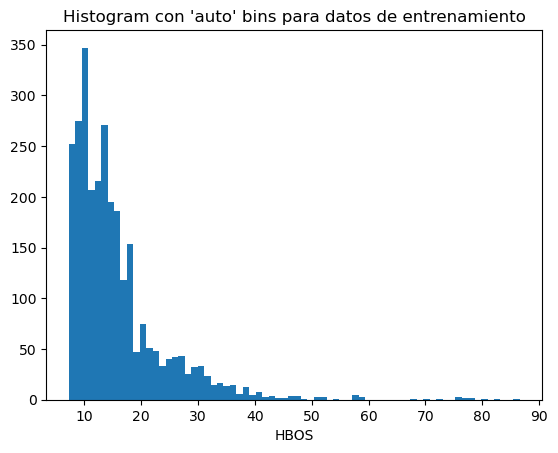

In [68]:
plt.hist(Y_test_scores, bins = 'auto')
plt.title("Histogram con 'auto' bins para datos de entrenamiento")
plt.xlabel('HBOS')
plt.show()

In [69]:
threshold = hbos.threshold_

In [70]:
threshold

32.29287805264419

In [71]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [72]:
# Obteniendo la tabla resumen de outliers en la data de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold)

,Group,Count,Count %,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,...,p3017_k,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score
0,Normal,6324,94.997747,37.90,37.99,0.32,0.34,0.53,3.12,5.56,...,5433.26,15841790.55,0.0,347527.21,17625.19,23050493.17,14144359.74,1.0,1.81,14.53
1,Outlier,333,5.002253,37.59,38.02,0.44,0.44,0.42,3.29,5.76,...,22291.29,16842688.40,0.0,443025.78,16245.90,28888172.00,21392700.93,1.0,1.73,41.66


In [73]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_train, Y_train_scores, threshold, 2)

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7167833,73,73.000000,0.322425,0.348412,0.526468,4,9,5,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,1.600000e+07,1.0,2.000000,28.284407,Normal
7238788,5,5.000000,0.322425,0.348412,0.526468,3,5,4,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,3.996947e+07,1.459818e+07,1.0,2.000000,16.255948,Normal
7167485,68,68.000000,0.322425,0.348412,0.526468,4,7,2,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,7.200000e+06,1.0,1.000000,20.137421,Normal
7244532,66,66.000000,0.322425,0.348412,0.526468,3,5,5,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,6.000000e+06,1.0,2.000000,8.601699,Normal
7062723,13,13.000000,0.322425,0.348412,0.526468,3,5,5,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,7.920000e+07,1.459818e+07,1.0,2.000000,7.970174,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211638,68,68.000000,0.322425,0.348412,0.526468,2,3,5,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,1.560000e+07,1.0,2.000000,12.392952,Normal
7263298,52,52.000000,0.322425,0.348412,0.526468,3,5,3,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,4.158000e+06,1.459818e+07,1.0,2.000000,14.307783,Normal
7095502,23,23.000000,1.000000,0.000000,0.000000,3,5,3,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,1.100000e+08,1.459818e+07,1.0,2.000000,33.046461,Outlier


In [74]:
# Obteniendo la tabla resumen de outliers en la data de validación
descriptive_stat_threshold(X_test, Y_test_scores, threshold)

,Group,Count,Count %,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,...,p3017_k,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score
0,Normal,2713,95.092885,37.72,37.34,0.32,0.34,0.53,3.13,5.53,...,5412.25,15884388.83,0.0,339674.87,18651.96,22985666.09,14219968.83,1.0,1.80,14.46
1,Outlier,140,4.907115,43.36,41.84,0.42,0.48,0.39,3.36,6.04,...,2892.86,17247731.38,0.0,323399.01,16579.09,30817570.94,26265609.51,1.0,1.63,43.14


In [75]:
# Obteniendo la data en la data de clasificación en con los datos de entrenamiento
descriptive_stat_threshold(X_test, Y_test_scores, threshold, 2)

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7187679,8,8.000000,0.322425,0.348412,0.526468,4,12,2,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,4.200000e+06,1.0,1.000000,14.985919,Normal
2127243,8,8.000000,0.322425,0.348412,0.526468,3,5,1,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,3.750000e+07,1.459818e+07,1.0,2.000000,10.102449,Normal
7255580,50,50.000000,0.322425,0.348412,0.526468,3,5,2,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,1.920000e+07,1.459818e+07,1.0,2.000000,9.811548,Normal
7191078,54,54.000000,0.322425,0.348412,0.526468,3,5,4,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,1.680000e+07,1.459818e+07,1.0,1.000000,18.394931,Normal
7240626,44,37.861222,0.322425,0.348412,0.526468,3,5,4,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,6.400000e+06,1.459818e+07,1.0,2.000000,8.697707,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108211,23,37.861222,0.322425,0.348412,0.526468,4,12,4,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,3.500000e+06,1.0,2.000000,12.363047,Normal
7074974,17,17.000000,0.322425,0.348412,0.526468,4,7,4,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,3.600000e+06,1.0,2.000000,11.071132,Normal
7002123,47,47.000000,0.322425,0.348412,0.526468,3,5,3,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,1.680000e+07,1.459818e+07,1.0,2.000000,13.771080,Normal


In [39]:
# Corroborando este dato outlier, con id = 601662015, en la base original:
emicron.loc[601662015,:]

cod_depto                        76.0
area                             76.0
clase_te                          1.0
p35                               2.0
p241                             58.0
                              ...    
ventas_mes_anterior         1600000.0
ventas_mes_anio_anterior     960000.0
ventas_anio_anterior        2000000.0
valor_agregado              1015000.0
ingreso_mixto               1015000.0
Name: 601662015, Length: 141, dtype: float64

In [76]:
# Estandarizando los datos

X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Generando diez modelos HBOS por rangos de 5, 10, 15, 20, 25, 30, 50, 60, 70 y 100 bins
# testando el rango de agrupaciones (binning)
k_list = [5,10,15,20,25,30,50,60,75,100]
n_clf = len(k_list)
# Se crea un dataframe vacío para los datos de entrenamiento y de test para almacenar las predicciones. Habrá diez modelos por lo que el data frame tendrá 10 columnas
#Almacenar los resultados
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modelando

for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins = n_bins)
    hbos.fit(X_train_norm)
    # Almacenando los resultados en cada columna
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)

# Normzalizando los puntajes de decision después de combinarlos
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

In [77]:
train_scores_norm

array([[ 1.32934657,  1.32934657,  1.32934657, ...,  1.32934657,
         1.32934657,  1.32934657],
       [-0.14239774, -0.14239774, -0.14239774, ..., -0.14239774,
        -0.14239774, -0.14239774],
       [ 0.34464697,  0.34464697,  0.34464697, ...,  0.34464697,
         0.34464697,  0.34464697],
       ...,
       [ 2.25092201,  2.25092201,  2.25092201, ...,  2.25092201,
         2.25092201,  2.25092201],
       [-1.09080761, -1.09080761, -1.09080761, ..., -1.09080761,
        -1.09080761, -1.09080761],
       [ 1.11182001,  1.11182001,  1.11182001, ...,  1.11182001,
         1.11182001,  1.11182001]])

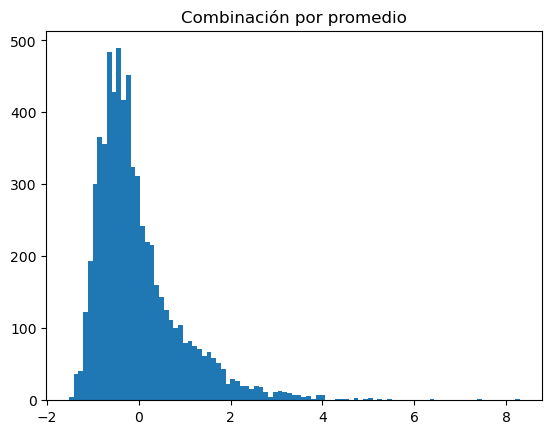

In [80]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_train_by_average = average(train_scores_norm)
Y_test_by_average = average(test_scores_norm)
plt.hist(Y_train_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [81]:
# Dado que el histograma anterior sugiere que el umbral esté por encima de 4.2, este será el umbral para categorizar lo valores anómalos
descriptive_stat_threshold(X_train, Y_train_by_average, 4)

,Group,Count,Count %,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,...,p3017_k,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score
0,Normal,6612,99.32402,37.83,37.94,0.32,0.35,0.53,3.12,5.56,...,6069.71,15884044.39,0.0,352542.40,17564.96,23263290.53,14323461.92,1.0,1.81,-0.04
1,Outlier,45,0.67598,46.20,44.45,0.98,0.27,0.35,3.42,6.24,...,36666.67,17039937.48,0.0,317318.01,16267.35,34982291.33,41466004.48,1.0,1.53,5.51


In [83]:
descriptive_stat_threshold(X_train, Y_train_by_average, 4, 2)

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7167833,73,73.000000,0.322425,0.348412,0.526468,4,9,5,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,1.600000e+07,1.0,2.000000,1.329347,Normal
7238788,5,5.000000,0.322425,0.348412,0.526468,3,5,4,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,3.996947e+07,1.459818e+07,1.0,2.000000,-0.142398,Normal
7167485,68,68.000000,0.322425,0.348412,0.526468,4,7,2,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,7.200000e+06,1.0,1.000000,0.344647,Normal
7244532,66,66.000000,0.322425,0.348412,0.526468,3,5,5,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,6.000000e+06,1.0,2.000000,-0.317076,Normal
7062723,13,13.000000,0.322425,0.348412,0.526468,3,5,5,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,7.920000e+07,1.459818e+07,1.0,2.000000,-0.570397,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211638,68,68.000000,0.322425,0.348412,0.526468,2,3,5,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,1.560000e+07,1.0,2.000000,-0.557884,Normal
7263298,52,52.000000,0.322425,0.348412,0.526468,3,5,3,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,4.158000e+06,1.459818e+07,1.0,2.000000,-0.082428,Normal
7095502,23,23.000000,1.000000,0.000000,0.000000,3,5,3,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,1.100000e+08,1.459818e+07,1.0,2.000000,2.250922,Normal


In [84]:
tabla_anomalos_emicron = descriptive_stat_threshold(X_train, Y_train_by_average, 4, 2)

In [85]:
atipicos = tabla_anomalos_emicron[tabla_anomalos_emicron['Group'] == 'Outlier']
atipicos.head()

,cod_depto,area,p3032_1,p3032_2,p3032_3,grupos4,grupos12,p639,p3053,p3054,...,p4019,p4020,p4021,p4022,p4023,p4027,p1764_1,p1765,Anomaly_Score,Group
directorio,,,,,,,,,,,,,,,,,,,,,
7008785,50,50.0,1.0,0.0,0.0,4,7,5,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,0.000000e+00,1.0,1.0,5.952340,Outlier
5018939,70,70.0,0.0,0.0,1.0,3,5,4,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,1.588055e+07,1.459818e+07,1.0,2.0,4.565359,Outlier
5036322,54,54.0,1.0,0.0,1.0,4,7,4,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,4.680000e+07,1.0,1.0,6.108634,Outlier
7094712,13,13.0,1.0,0.0,2.0,4,7,5,4,1.000000,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,2.530667e+07,1.0,1.0,5.498864,Outlier
7032920,18,18.0,0.0,1.0,0.0,4,9,3,4,1.063586,...,1.590969e+07,0.0,348275.862069,17854.40613,2.335075e+07,2.800000e+07,1.0,2.0,6.912085,Outlier


In [86]:
atipicos['Anomaly_Score'].mean()

5.512601726953174

In [87]:
atipicos.to_excel('datos/HBOS_tabla_anomalos_emicron22_homologadas_cenu.xlsx', index = True)